In [1]:
%load_ext autoreload
%autoreload 2
%run ./initializer

Added the path (/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1) to sys.path


In [2]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, split_train_val, objective, train_epoch, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

/Users/rik/Documents/VU/DMT/DataMiningTechniquesA1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
data_loader = DataPreprocessor()
train_df, test_df = data_loader.load_and_preprocess_data("1d")

shape: (1_973,)
Series: 'appCat.weather' [f64]
[
	null
	null
	null
	null
	null
	…
	null
	null
	null
	null
	null
]


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df['id'].unique())}
input_dim = train_df.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df['mood'].max() + 1

train_df_split, val_df_split = split_train_val(train_df, fraction=0.2)

In [5]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-17 19:55:46,029] A new study created in memory with name: no-name-5d9b97ca-7a65-4476-9f44-e9e082f1ed50
[I 2025-04-17 19:55:51,103] Trial 0 finished with value: 0.8934529423713684 and parameters: {'hidden_dim': 95, 'id_embed_dim': 8, 'lr': 0.0007393780875508301, 'batch_size': 64, 'alpha': 0.27028523778182717}. Best is trial 0 with value: 0.8934529423713684.
[I 2025-04-17 19:55:51,286] Trial 1 finished with value: 0.5743939876556396 and parameters: {'hidden_dim': 117, 'id_embed_dim': 15, 'lr': 0.008814430375396134, 'batch_size': 64, 'alpha': 0.15535824506239235}. Best is trial 1 with value: 0.5743939876556396.
[I 2025-04-17 19:55:51,464] Trial 2 finished with value: 0.5766007751226425 and parameters: {'hidden_dim': 105, 'id_embed_dim': 6, 'lr': 0.0015547601672354615, 'batch_size': 64, 'alpha': 0.15861584247916563}. Best is trial 1 with value: 0.5743939876556396.
[I 2025-04-17 19:55:51,630] Trial 3 finished with value: 1.5530798435211182 and parameters: {'hidden_dim': 58, 'id_e

Best hyperparams: {'hidden_dim': 117, 'id_embed_dim': 13, 'lr': 0.004299061288182261, 'batch_size': 128, 'alpha': 0.010137349176671492}


In [6]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [7]:
for epoch in range(2000):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

Epoch 1: train loss = 0.4224, val loss = 0.3331
Epoch 2: train loss = 0.2143, val loss = 0.1688
Epoch 3: train loss = 0.1073, val loss = 0.0897
Epoch 4: train loss = 0.0676, val loss = 0.0633
Epoch 5: train loss = 0.0546, val loss = 0.0543
Epoch 6: train loss = 0.0494, val loss = 0.0519
Epoch 7: train loss = 0.0459, val loss = 0.0493
Epoch 8: train loss = 0.0442, val loss = 0.0492
Epoch 9: train loss = 0.0426, val loss = 0.0481
Epoch 10: train loss = 0.0419, val loss = 0.0492
Epoch 11: train loss = 0.0408, val loss = 0.0483
Epoch 12: train loss = 0.0404, val loss = 0.0491
Epoch 13: train loss = 0.0398, val loss = 0.0485
Epoch 14: train loss = 0.0386, val loss = 0.0497
Epoch 15: train loss = 0.0384, val loss = 0.0497
Epoch 16: train loss = 0.0377, val loss = 0.0502
Epoch 17: train loss = 0.0370, val loss = 0.0490
Epoch 18: train loss = 0.0368, val loss = 0.0512
Epoch 19: train loss = 0.0361, val loss = 0.0495
Epoch 20: train loss = 0.0355, val loss = 0.0513
Epoch 21: train loss = 0.0355

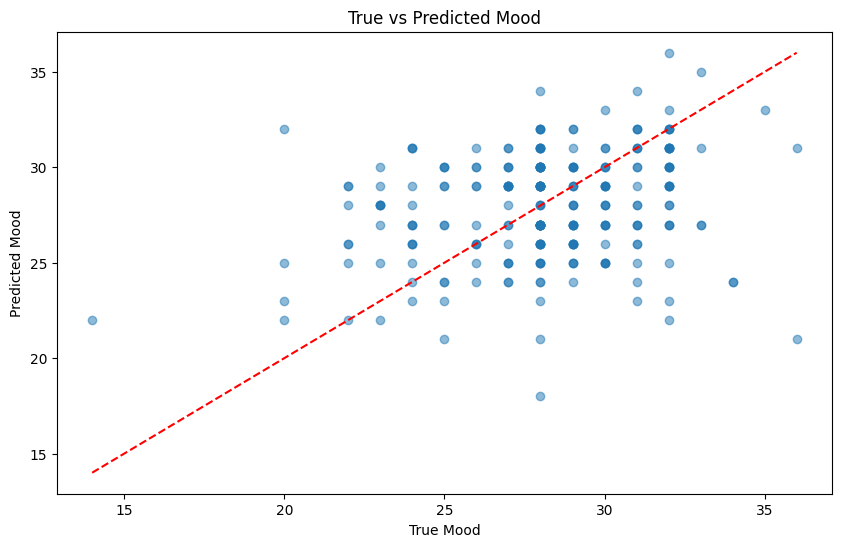

In [11]:
plot_mood_predictions(model, val_loader, device)

In [9]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    30
1   AS14.02                    25
2   AS14.03                    24
3   AS14.05                    29
4   AS14.06                    33
5   AS14.07                    26
6   AS14.08                    26
7   AS14.09                    29
8   AS14.12                    26
9   AS14.13                    31
10  AS14.14                    26
11  AS14.15                    29
12  AS14.16                    29
13  AS14.17                    28
14  AS14.19                    31
15  AS14.20                    26
16  AS14.23                    32
17  AS14.24                    27
18  AS14.25                    23
19  AS14.26                    27
20  AS14.27                    31
21  AS14.28                    27
22  AS14.29                    24
23  AS14.30                    29
24  AS14.31                    32
25  AS14.32                    27
26  AS14.33                    26


In [12]:
test_df

,id,date,circumplex.arousal,circumplex.valence,activity,lagged_mood,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,...,appCat.unknown,appCat.utilities,appCat.weather,call,mood,screen,sms,day_of_week,step,days_since_last_obs
0,AS14.01,2014-05-05,-0.608451,0.741290,-1.122363,1.277717,-0.232045,-0.684146,-0.290839,-0.222202,...,-0.227556,1.557465,-0.199723,-0.680786,32.0,-0.819495,-0.451866,-1.523822,1.291186,-0.032541
1,AS14.02,2014-04-25,-1.371188,0.741290,-0.846597,2.634312,-0.348711,-1.014385,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,28.0,-1.190682,-0.451866,0.472601,0.724486,-0.032541
2,AS14.03,2014-05-08,-0.862697,0.741290,-1.203546,0.938569,-0.348711,-1.014385,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,31.0,-1.190682,-0.451866,-0.026505,1.461196,1.340934
3,AS14.05,2014-05-05,-0.354206,0.741290,-1.177764,-0.757174,-0.348711,-1.001296,-0.475535,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,28.0,-1.180507,-0.451866,-1.523822,1.234516,-0.032541
4,AS14.06,2014-05-08,-1.371188,0.741290,-1.203546,-0.078877,-0.348711,-0.893175,-0.469772,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,27.0,-1.190682,-0.451866,-0.026505,1.461196,1.340934
5,AS14.07,2014-05-05,-2.133924,-0.430561,-0.351702,-2.113768,-0.348711,-1.014385,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,32.0,-1.190682,-0.451866,-1.523822,-0.295573,-0.032541
6,AS14.08,2014-05-05,-1.371188,0.741290,-1.176589,-0.418025,-0.348711,-0.999773,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,28.0,-1.135937,-0.451866,-1.523822,1.291186,-0.032541
7,AS14.09,2014-05-05,-1.371188,-0.430561,-0.062091,-1.435471,-0.348711,-1.014385,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,27.0,-1.190682,-0.451866,-1.523822,1.291186,-0.032541
8,AS14.12,2014-05-05,0.154285,-0.821178,-0.871864,-1.435471,0.009194,-0.607143,-0.398595,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.092725,20.0,-0.717215,-0.451866,-1.523822,1.177846,-0.032541
9,AS14.13,2014-05-04,-1.371188,0.741290,1.113571,1.277717,-0.348711,-1.014385,-0.478573,-0.222202,...,-0.227556,-0.245516,-0.199723,-0.680786,29.0,-1.190682,-0.451866,1.470812,1.234516,-0.032541


In [10]:
train_df = train_df.sort_values('mood')
train_df['mood'].unique(), train_df['mood'].value_counts()

(array([12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 38], dtype=int32),
 mood
 28    301
 29    138
 32    128
 30    124
 26    103
 27     98
 31     98
 24     66
 25     65
 33     21
 22     17
 23     17
 34     13
 20      7
 35      6
 21      5
 36      4
 14      3
 18      3
 19      2
 15      2
 12      1
 16      1
 38      1
 Name: count, dtype: int64)